In [1]:
from itertools import combinations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from pandas.api.types import is_numeric_dtype
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from sklearn.metrics import classification_report, f1_score, make_scorer, ConfusionMatrixDisplay

Estamos refinando o conjunto de dados principal para atender a um objetivo comercial claro: criar um modelo que preveja o resultado acadêmico final de um aluno. Para fazer isso de forma eficaz, o modelo deve ser treinado em dados com resultados históricos confirmados. Os registros de alunos que ainda estão “Matriculados” representam um status incerto, em andamento, e não um resultado final. A inclusão dessa ambiguidade introduziria ruído e comprometeria a capacidade do modelo de aprender os padrões distintos que diferenciam os alunos que acabam se formando dos que desistem.


O arquivo exportado que contém os alunos “matriculados” é preservado para a aplicação principal do modelo. Depois que nosso modelo for treinado e validado nos dados históricos, nós o usaremos para prever os resultados futuros para esse grupo de “matriculados”. Isso nos permite gerar uma pontuação de risco de evasão para cada aluno ativo no momento, permitindo que a instituição identifique proativamente indivíduos em risco e implemente intervenções direcionadas para melhorar a retenção.

In [2]:
df = pd.read_csv('./data/dataset.csv')

enrolled_df = df[df['Target'] == 'Enrolled'].copy()
enrolled_df.to_csv('./data/enrolled_students.csv', index=False)

df = df[df['Target'] != 'Enrolled']

cols_to_convert_to_category = [
    'Marital status', 'Application mode', 'Course', 'Daytime/evening attendance',
    'Previous qualification', 'Nacionality', "Mother's qualification", 
    "Father's qualification", "Mother's occupation", "Father's occupation", 
    'Displaced', 'Educational special needs', 'Debtor', "Target",
    'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International'
]

for col in cols_to_convert_to_category:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Analise Exploratória dos Dados

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3630 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   Marital status                                  3630 non-null   category
 1   Application mode                                3630 non-null   category
 2   Application order                               3630 non-null   int64   
 3   Course                                          3630 non-null   category
 4   Daytime/evening attendance                      3630 non-null   category
 5   Previous qualification                          3630 non-null   category
 6   Nacionality                                     3630 non-null   category
 7   Mother's qualification                          3630 non-null   category
 8   Father's qualification                          3630 non-null   category
 9   Mother's occupation                

In [4]:
df.describe()

,Application order,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000
mean,1.750138,23.461157,0.754270,6.337466,8.071074,4.791460,10.534860,0.128926,0.581818,6.296419,7.763085,4.518457,10.036155,0.142149,11.630358,1.231598,-0.009256
std,1.333831,7.827994,2.477277,2.570773,4.286632,3.237845,5.057694,0.679111,2.022688,2.263020,3.964163,3.162376,5.481742,0.747670,2.667652,1.384911,2.259986
min,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,19.000000,0.000000,5.000000,6.000000,3.000000,11.000000,0.000000,0.000000,5.000000,6.000000,2.000000,10.517857,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,20.000000,0.000000,6.000000,8.000000,5.000000,12.341429,0.000000,0.000000,6.000000,8.000000,5.000000,12.333333,0.000000,11.100000,1.400000,0.320000
75%,2.000000,25.000000,0.000000,7.000000,10.000000,6.000000,13.500000,0.000000,0.000000,7.000000,10.000000,6.000000,13.500000,0.000000,13.900000,2.600000,1.790000
max,6.000000,70.000000,20.000000,26.000000,45.000000,26.000000,18.875000,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


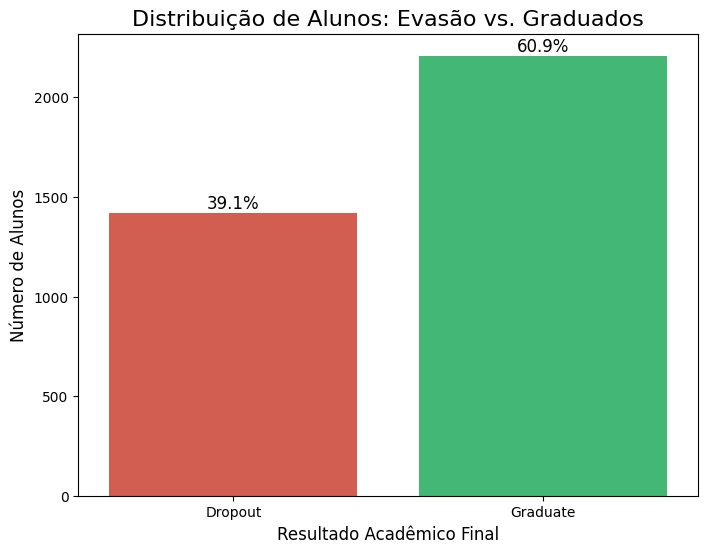

In [5]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Target', data=df, palette=['#E74C3C', '#2ECC71'])

plt.title('Distribuição de Alunos: Evasão vs. Graduados', fontsize=16)
plt.xlabel('Resultado Acadêmico Final', fontsize=12)
plt.ylabel('Número de Alunos', fontsize=12)

total = len(df['Target'])
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12)

plt.show()

Este gráfico mostra a proporção exata entre evasões e formaturas. As classes estão muito desbalanceadas (ex: 60.9% de graduados e 39.1% de evasão), talvez seja necessário usar técnicas de amostragem (como SMOTE ou ADASYN), métricas de avaliação específicas (como F1-Score) e uso de peso de classes durante a modelagem.

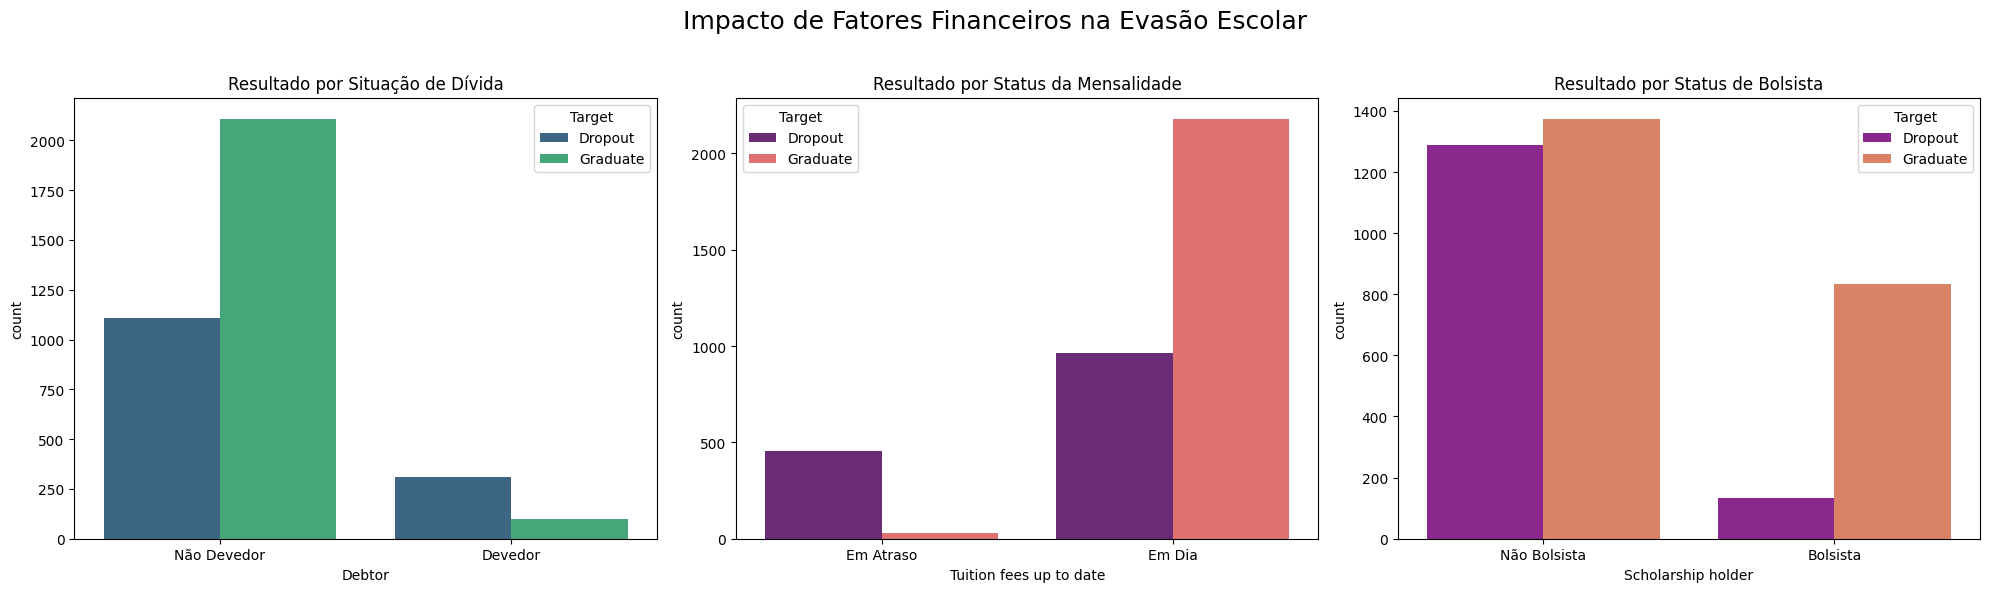

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Impacto de Fatores Financeiros na Evasão Escolar', fontsize=18)

sns.countplot(ax=axes[0], x='Debtor', hue='Target', data=df, palette='viridis')
axes[0].set_title('Resultado por Situação de Dívida')
axes[0].set_xticklabels(['Não Devedor', 'Devedor'])

sns.countplot(ax=axes[1], x='Tuition fees up to date', hue='Target', data=df, palette='magma')
axes[1].set_title('Resultado por Status da Mensalidade')
axes[1].set_xticklabels(['Em Atraso', 'Em Dia'])

sns.countplot(ax=axes[2], x='Scholarship holder', hue='Target', data=df, palette='plasma')
axes[2].set_title('Resultado por Status de Bolsista')
axes[2].set_xticklabels(['Não Bolsista', 'Bolsista'])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Os gráficos mostram que ter dívidas ou mensalidades em atraso está fortemente correlacionado com a evasão. Por outro lado, ser bolsista tende a estar associado a uma maior taxa de graduação, possivelmente por reduzir a pressão financeira e selecionar alunos com bom desempenho.

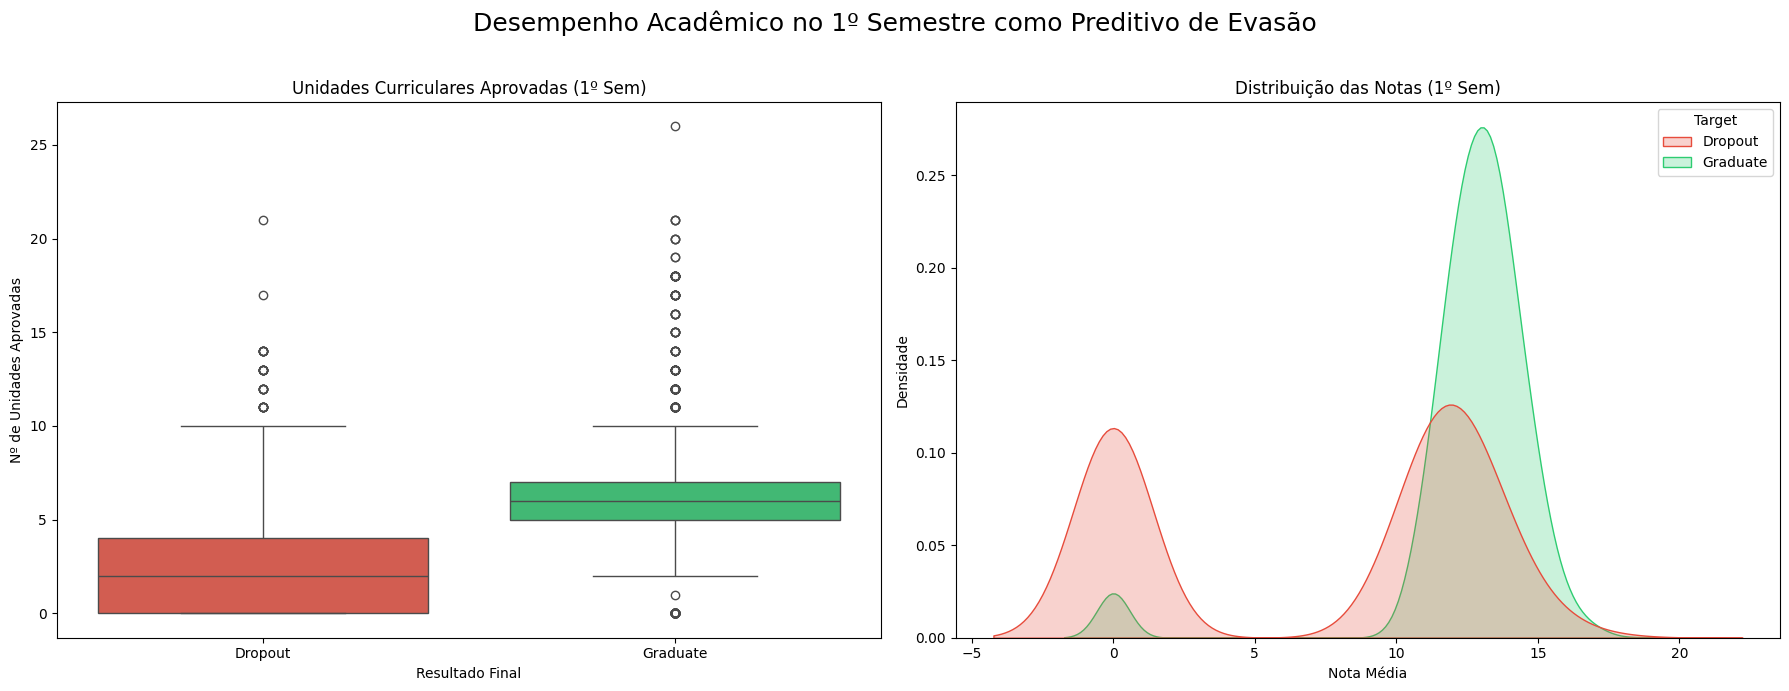

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Desempenho Acadêmico no 1º Semestre como Preditivo de Evasão', fontsize=18)

sns.boxplot(ax=axes[0], x='Target', y='Curricular units 1st sem (approved)', data=df, palette=['#E74C3C', '#2ECC71'])
axes[0].set_title('Unidades Curriculares Aprovadas (1º Sem)')
axes[0].set_xlabel('Resultado Final')
axes[0].set_ylabel('Nº de Unidades Aprovadas')


sns.kdeplot(data=df, x='Curricular units 1st sem (grade)', hue='Target',
            fill=True, common_norm=False, palette=['#E74C3C', '#2ECC71'])
axes[1].set_title('Distribuição das Notas (1º Sem)')
axes[1].set_xlabel('Nota Média')
axes[1].set_ylabel('Densidade')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Fica evidente que alunos que aprovam mais matérias e têm notas mais altas logo no primeiro semestre têm uma chance muito maior de se graduar. Uma baixa contagem de aprovações é um forte sinal de alerta precoce para a evasão.

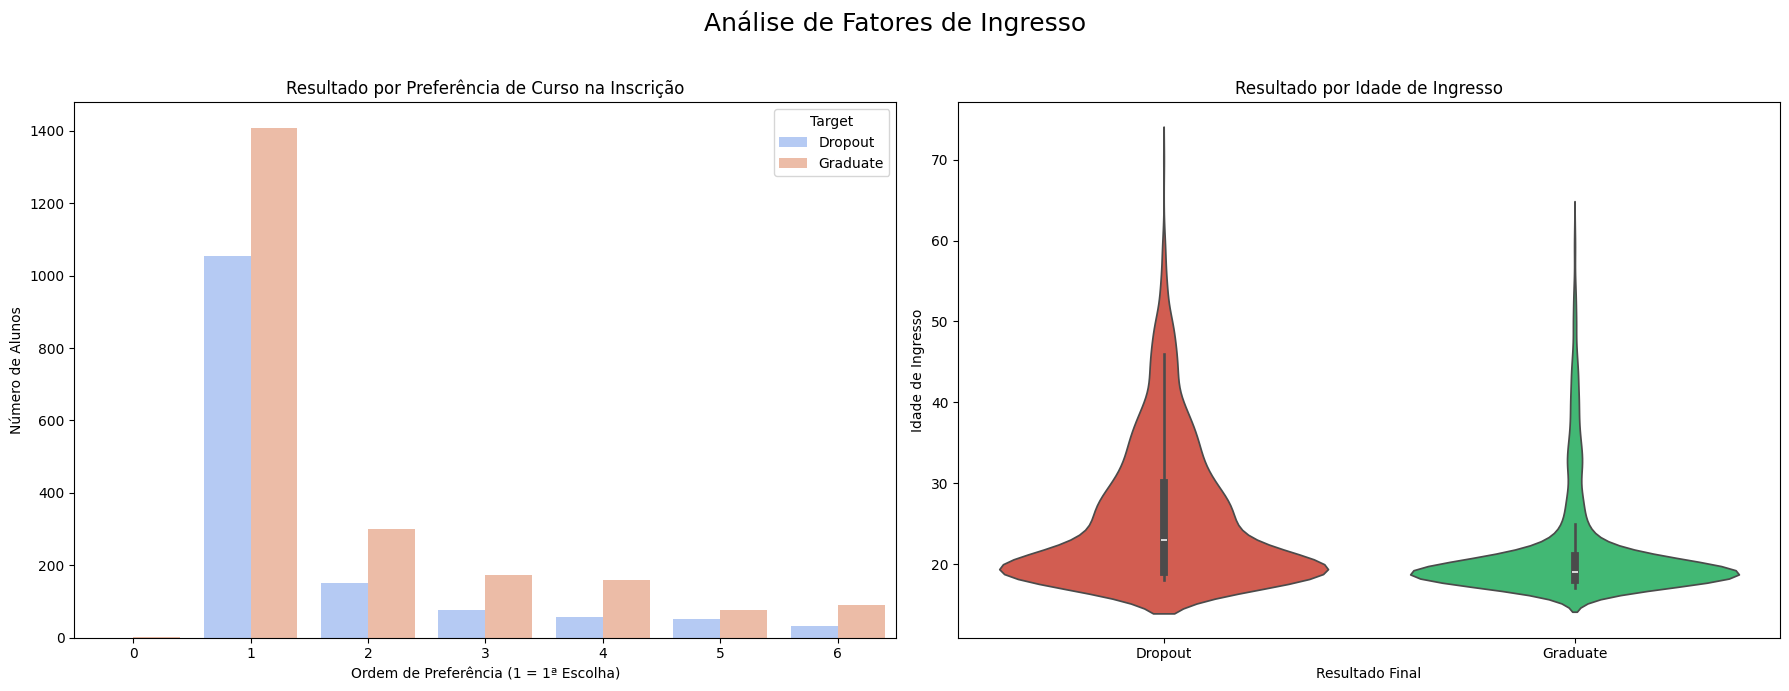

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Análise de Fatores de Ingresso', fontsize=18)

sns.countplot(ax=axes[0], x='Application order', hue='Target', data=df, palette='coolwarm')
axes[0].set_title('Resultado por Preferência de Curso na Inscrição')
axes[0].set_xlabel('Ordem de Preferência (1 = 1ª Escolha)')
axes[0].set_ylabel('Número de Alunos')

sns.violinplot(ax=axes[1], x='Target', y='Age at enrollment', data=df, palette=['#E74C3C', '#2ECC71'])
axes[1].set_title('Resultado por Idade de Ingresso')
axes[1].set_xlabel('Resultado Final')
axes[1].set_ylabel('Idade de Ingresso')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Alunos que entram no curso de primeira escolha (Application order = 1) intuitivamente tendem a ser mais motivados e, consequentemente, têm uma taxa de evasão menor, mas o grafico acima nos mostra que a proporção de graduados e evasão continua a mesma quanto aumenta a Ordem de Preferência. A análise de idade pode revelar que alunos mais velhos (mature students) tem taxas de evasão ligeiramente maiores, talvez por terem que conciliar trabalho, estudo, família e outras responsabilidades que se tem quando é mais velho.

## Analise Estatística

| Tipo de variável 1 | Tipo de variável 2 | Teste recomendado | Observação |
| :--- | :--- | :--- | :--- |
| Categórica | Categórica | Qui-quadrado (Chi-square) | Testa independência entre categorias |
| Numérica | Numérica | Correlação de Pearson (ou Spearman para não paramétrico) | Mede força e direção da relação linear |
| Categórica | Numérica | ANOVA (ou teste t para 2 grupos) | Testa diferença das médias da numérica entre grupos categóricos |
| Numérica | Categórica | ANOVA (mesma situação acima, só invertendo) | O teste é simétrico neste caso |
| Categórica (target) | Numérica | Modelos de classificação (e.g., regressão logística) e testes específicos | ANOVA não é indicado para associação com target categórico |
| Numérica (target) | Categórica | ANOVA (comparar médias entre grupos da categórica) | Clássico caso para ANOVA |

### Matriz de correlação de Pearson (Entre variáveis númericas)

É uma tabela que mostra o grau de associação linear entre pares de variáveis numéricas.

Ela usa o coeficiente de correlação de Pearson (r) para medir quanto duas variáveis se movem juntas, ou seja, o quanto aumentos ou diminuições em uma variável se associam a aumentos ou diminuições em outra.

| Valor de r | Interpretação |
| :--- | :--- |
| +1 | Correlação linear positiva perfeita |
| 0 | Sem correlação linear |
| -1 | Correlação linear negativa perfeita |

**Importante**: Pearson só mede relações lineares. Duas variáveis podem ser dependentes não-linearmente e ainda assim ter r ≈ 0.

Para duas variáveis X e Y com n observações, o coeficiente de correlação de Pearson r é calculado como:

$$
r = \frac{\sum_{i=1}^{n} (X_i - \bar{X})(Y_i - \bar{Y})}
         {\sqrt{\sum_{i=1}^{n} (X_i - \bar{X})^2} \cdot \sqrt{\sum_{i=1}^{n} (Y_i - \bar{Y})^2}}
$$

Onde:
- $Xᵢ$ e $Yᵢ$ são os valores individuais das variáveis $X$ e $Y$
- $𝑋̄$ e $𝑌̄$ são as médias das variáveis $X$ e $Y$
- O numerador é a covariância entre $X$ e $Y$
- O denominador é o produto dos desvios padrão de $X$ e $Y$

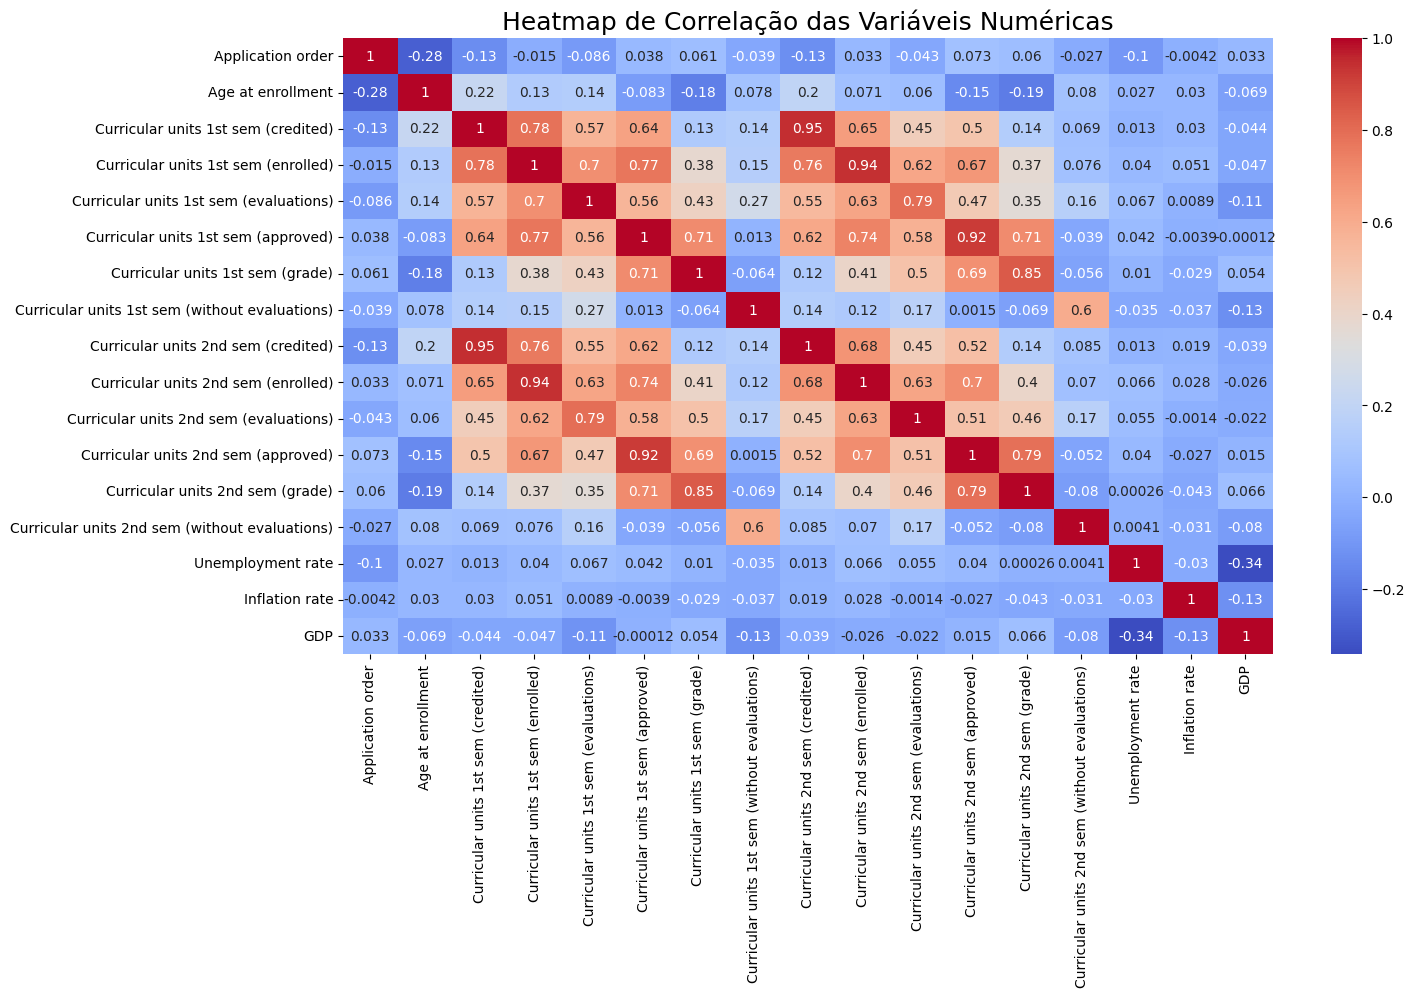

In [9]:
numeric_cols = df.select_dtypes(include=np.number)

corr_matrix = numeric_cols.corr()

plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title('Heatmap de Correlação das Variáveis Numéricas', fontsize=18)
plt.show()

- **Dentro do mesmo semestre**: Variáveis como unidades matriculadas (enrolled), avaliadas (evaluations) e aprovadas (approved) são fortemente correlacionadas. Isso é lógico: quem se matricula em mais matérias tende a ter mais avaliações e a ser aprovado em mais unidades. A nota do semestre (grade) também tem uma correlação muito forte com as unidades aprovadas (approved), com um valor de 0.71 no 1º semestre.

- **Entre semestres (Insight importante)**: A correlação mais forte e importante é entre o desempenho do 1º e do 2º semestre. A nota do 1º semestre (1st sem (grade)) tem uma correlação de 0.85 com a do 2º. Da mesma forma, as unidades aprovadas no 1º semestre têm correlação de 0.92 com as do 2º. Isso prova que o desempenho acadêmico passado é um preditor extremamente forte do desempenho futuro.

- **Possível Multicolinearidade**: O "bloco quente" envolvendo as variáveis `Curricular units ...` são um grande indicativo de multicolinearidade. Isso será analisado posteriormente usando a técnica de Fator de Inflação de Variância (VIF).

### Testes de Hipótese


#### ANOVA (Análise de Variância): 
Testa se existe uma diferença estatisticamente significativa entre as médias de uma variável numérica em dois ou mais grupos de uma variável categórica

- **ANOVA pergunta**: "Essa variável categórica está associada a diferenças significativas na média de uma variável contínua?"
    - Se sim, ela traz informação útil e pode ser uma boa candidata como variável explicativa.

1. **Hipótese nula** ($H_0$):
    - Não há diferença significativa entre os grupos.
    - Ou seja: a variável categórica não tem efeito sobre a variável numérica.
    - As médias dos grupos (categorias) são iguais.

➡ Isso implica que não há associação estatística entre as variáveis. É possível considerar o descarte de uma das variáveis, ou realizar um feature engineering.

2. **Hipótese alternativa** ($H_1$):
    - Há pelo menos uma diferença significativa entre os grupos.
    - Ou seja: a variável categórica tem efeito sobre a variável numérica.
    - As médias dos grupos são diferentes.

➡ Isso indica associação significativa entre a variável categórica e a numérica. Feature engineering pode não ser necessária nesse ponto, porque a relação já está clara, mas ainda pode valer a pena melhorar a representação.

- $p > 0.05$ >>> Não rejeita $H_0$ → Não há evidência de diferença entre os grupos → Sem associação
- $p ≤ 0.05$ >>> Rejeita $H_0$ e aceita $H_1$ → Existe evidência de que os grupos diferem → Há associação

In [10]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = df.select_dtypes(include=np.number).columns.tolist()

if 'Target' in categorical_features:
    categorical_features.remove('Target')

anova_results = []

for cat_col in categorical_features:
    for num_col in numerical_features:
        # Pular se a variável categórica tiver muitas categorias (torna o teste lento/ruim)
        if df[cat_col].nunique() > 50:
            continue
            
        # Agrupar os dados numéricos pelas categorias da variável categórica
        groups = df.groupby(cat_col)[num_col].apply(list)
        
        if len(groups) < 2:
            continue
        
        try:
            f_statistic, p_value = f_oneway(*groups)
            anova_results.append({
                'Variável Categórica': cat_col,
                'Variável Numérica': num_col,
                'Estatístfor o núcleoica F': f_statistic,
                'p-valor': p_value
            })
        except Exception as e:
            # Ignorar pares que causam erros (ex: grupos com dados insuficientes)
            pass

results_df = pd.DataFrame(anova_results)

results_df_sorted = results_df.sort_values(by='p-valor', ascending=True)

print("Exibindo as 15 relações mais significativas:")
display(results_df_sorted.head(15))

print("Exibindo as 15 relações menos significativas:")
display(results_df_sorted.tail(15))


Exibindo as 15 relações mais significativas:


,Variável Categórica,Variável Numérica,Estatístfor o núcleoica F,p-valor
18,Application mode,Age at enrollment,280.745529,0.000000e+00
1,Marital status,Age at enrollment,502.811925,0.000000e+00
43,Course,Curricular units 2nd sem (enrolled),118.447943,1.049518e-315
35,Course,Age at enrollment,80.506006,6.580430e-225
37,Course,Curricular units 1st sem (enrolled),72.907779,1.995195e-205
19,Application mode,Curricular units 1st sem (credited),67.502645,1.850651e-201
69,Previous qualification,Age at enrollment,71.022735,1.607919e-200
52,Daytime/evening attendance,Age at enrollment,940.584260,7.200418e-184
25,Application mode,Curricular units 2nd sem (credited),58.741694,7.155714e-177
40,Course,Curricular units 1st sem (grade),60.424144,2.246295e-172


Exibindo as 15 relações menos significativas:


,Variável Categórica,Variável Numérica,Estatístfor o núcleoica F,p-valor
276,International,Curricular units 1st sem (evaluations),0.163568,0.685916
280,International,Curricular units 2nd sem (credited),0.141132,0.707180
162,Father's occupation,Curricular units 2nd sem (enrolled),0.868774,0.707389
287,International,Inflation rate,0.126691,0.721909
265,Scholarship holder,Curricular units 2nd sem (evaluations),0.126421,0.722193
277,International,Curricular units 1st sem (approved),0.112094,0.737792
67,Daytime/evening attendance,GDP,0.090973,0.762961
253,Gender,Inflation rate,0.072378,0.787921
202,Educational special needs,Inflation rate,0.071908,0.788594
97,Nacionality,Curricular units 2nd sem (grade),0.722345,0.791122


- **Idade de Ingresso (Age at enrollment) é Central**: A idade do aluno é a variável numérica mais influenciada por fatores categóricos. Ela está fortemente associada ao Estado Civil, Modo de Aplicação, Curso, Qualificação Prévia e se o aluno é Deslocado. Isso indica que diferentes perfis demográficos ingressam na universidade em idades significativamente diferentes, o que, por si só, é um poderoso agrupador de comportamento.

- **O Curso (Course) Define o Desempenho**: Como esperado, o curso escolhido tem um impacto massivo em todas as métricas de desempenho acadêmico: unidades matriculadas (enrolled), notas (grade) e unidades aprovadas (approved). Isso confirma que a dificuldade e a carga de trabalho variam drasticamente entre os cursos, tornando esta uma das features mais importantes para prever o sucesso de um aluno.

- **O Histórico Importa**: A Qualificação Prévia (Previous qualification) e o Modo de Aplicação (Application mode) estão fortemente ligados tanto à idade quanto aos créditos iniciais. Isso mostra que a "bagagem" que o aluno traz para a universidade já o coloca em uma trajetória de desempenho distinta.

- **Status de International é um Preditor Fraco (Isoladamente)**: A descoberta mais notável aqui é que ser ou não um estudante internacional não tem uma associação estatisticamente significativa com quase nenhuma métrica de desempenho acadêmico (notas, aprovações, avaliações). Isso sugere que, neste dataset, o desempenho dos alunos internacionais é estatisticamente indistinguível do dos alunos nacionais, tornando essa variável, sozinha, um preditor fraco.

- **Demografia Secundária com Baixo Impacto**: Variáveis como Ocupação do Pai (Father's occupation), Nacionalidade (Nacionality) e Gênero (Gender), quando cruzadas com as métricas numéricas, mostraram uma relação muito fraca (p-valor alto). Elas provavelmente têm menos poder preditivo direto do que as variáveis da primeira tabela.

- **Fatores Macroeconômicos Difusos**: A Taxa de Inflação e o PIB não se mostraram associados a características individuais como gênero ou nacionalidade, o que faz sentido, pois são indicadores que afetam a todos de forma mais ampla e menos direta.


#### Qui-Quadrado

Este teste avalia se existe uma associação estatisticamente significativa entre duas variáveis categóricas. A hipótese nula $H_0​$ é que as variáveis são independentes (não há associação, com $p > 0.05$) e a hipótese alternativa $H_1$ é que existe uma associação ($p ≤ 0.05$).

O Qui-Quadrado consegue analisar associações entre a nossa variável Target (que é categórica) e outras variáveis explicativas categóricas.

**OBS**: A ANOVA analisa o impacto de uma variável categórica nas médias de uma variável numérica, A variável categórica define os grupos (por exemplo: `aprovado`, `reprovado`, `evadiu`), e a variável numérica é a que está sendo analisada em relação às diferenças entre esses grupos (ex: média de notas, horas de estudo, renda etc.). No nosso caso, queremos sabe se a variável categórica `Target` (evasão escolar) pode ser explicada por uma variável numérica (ex: renda, idade, nota), acontece que a ANOVA não foi projetada para testar isso diretamente, porque o foco da ANOVA está na variável numérica como variável de interesse, e a categórica como variável explicativa, e não o contrário. O teste de **Qui-quadrado** entra para resolver esse problema.

Relações mais significativas:


,Variável 1,Variável 2,Estatística Chi2,p-valor
20,Application mode,Nacionality,3375.483418,0.000000e+00
19,Application mode,Previous qualification,10302.630410,0.000000e+00
33,Course,Daytime/evening attendance,3630.000000,0.000000e+00
108,Mother's occupation,Father's occupation,42264.249558,0.000000e+00
87,Mother's qualification,Father's qualification,20115.447190,0.000000e+00
85,Nacionality,International,3630.000000,0.000000e+00
89,Mother's qualification,Father's occupation,5888.401307,0.000000e+00
88,Mother's qualification,Mother's occupation,7165.054597,0.000000e+00
99,Father's qualification,Father's occupation,5162.093150,0.000000e+00
98,Father's qualification,Mother's occupation,3494.673706,3.329569e-294




Associações mais fortes com a variável 'Target':


,Variável 1,Variável 2,Estatística Chi2,p-valor
146,Tuition fees up to date,Target,706.955139,9.189124e-156
47,Course,Target,442.947968,3.497695e-84
151,Scholarship holder,Target,354.219302,5.109075e-79
32,Application mode,Target,392.065918,8.435153e-73
142,Debtor,Target,257.459618,6.141424e-58
149,Gender,Target,229.351510,8.255974e-52
74,Previous qualification,Target,150.599021,5.952453e-24
97,Mother's qualification,Target,143.014288,2.201217e-17
116,Mother's occupation,Target,138.235113,1.555138e-16
107,Father's qualification,Target,147.861704,1.754550e-16


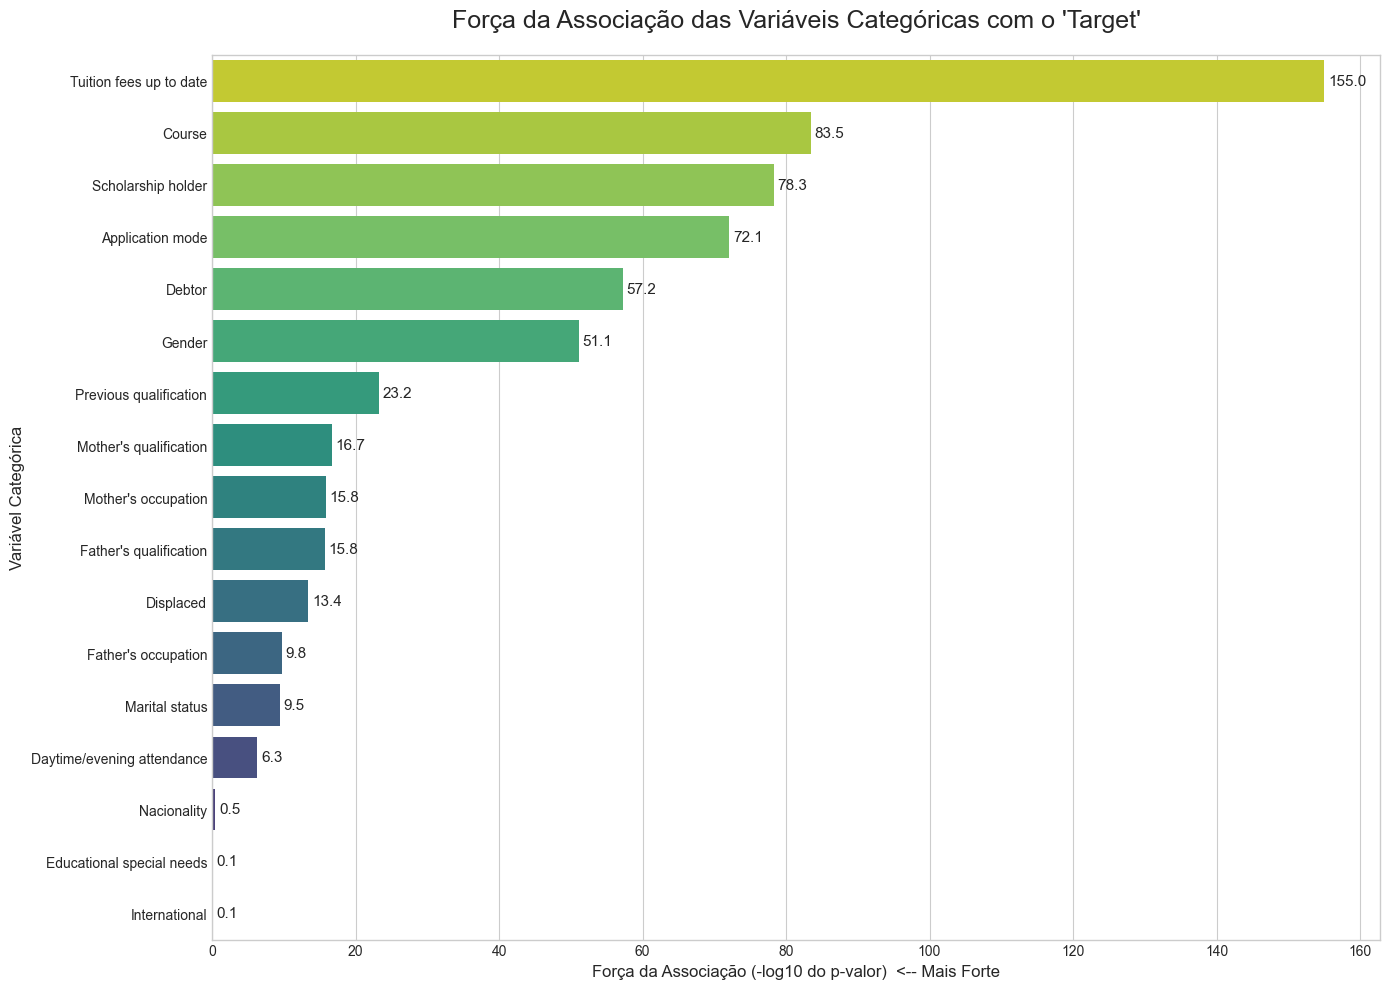

In [11]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_pairs = list(combinations(categorical_features, 2))
chi2_results = []

for pair in cat_pairs:
    var1, var2 = pair[0], pair[1]
    
    contingency_table = pd.crosstab(df[var1], df[var2])
    
    try:
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        chi2_results.append({
            'Variável 1': var1,
            'Variável 2': var2,
            'Estatística Chi2': chi2,
            'p-valor': p_value
        })
    except Exception as e:
        # Algumas tabelas podem ter contagens zero, o que pode falhar o teste
        pass

results_df = pd.DataFrame(chi2_results)

results_df_sorted = results_df.sort_values(by='p-valor', ascending=True)

print("Relações mais significativas:")
display(results_df_sorted.head(20))

print("\n\nAssociações mais fortes com a variável 'Target':")
target_associations = results_df_sorted[
    (results_df_sorted['Variável 1'] == 'Target') | (results_df_sorted['Variável 2'] == 'Target')
].copy()
display(target_associations.head(20))

target_associations['Feature'] = target_associations.apply(
    lambda row: row['Variável 1'] if row['Variável 2'] == 'Target' else row['Variável 2'],
    axis=1
)

target_associations['Força da Associação (-log10 p-valor)'] = -np.log10(target_associations['p-valor'].replace(0, 1e-300))

plot_data = target_associations.sort_values(by='Força da Associação (-log10 p-valor)', ascending=False)

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 10))
ax = sns.barplot(
    data=plot_data,
    x='Força da Associação (-log10 p-valor)',
    y='Feature',
    palette='viridis_r',
    orient='h'
)

ax.set_title("Força da Associação das Variáveis Categóricas com o 'Target'", fontsize=18, pad=20)
ax.set_xlabel('Força da Associação (-log10 do p-valor)  <-- Mais Forte', fontsize=12)
ax.set_ylabel('Variável Categórica', fontsize=12)

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.5, p.get_y() + p.get_height() / 2,
            f'{width:.1f}',
            va='center',
            fontsize=11)

plt.tight_layout()
plt.show()


##### Tier 1: Os Preditores Dominantes (p-valor $< e-50$)

Estas são as variáveis com a conexão mais forte com a evasão. Elas devem estar presentes em qualquer modelo preditivo que for construído.

- **Tuition fees up to date (Mensalidades em dia)**: Com um p-valor astronômico de aproximadamente $e^-156$, esta é, de longe, a variável mais impactante. A associação é tão forte que o status financeiro do aluno com a instituição é quase um veredito sobre seu resultado. A mensagem é clara: dificuldade financeira é a principal causa de evasão.

- **Course (Curso)**: A segunda variável mais forte. Confirma que o curso escolhido pelo aluno é um fator determinante para seu sucesso. Alguns cursos podem ter taxas de evasão intrinsecamente mais altas devido à dificuldade, estrutura ou alinhamento com o mercado.

- **Scholarship holder (Bolsista)**: Funciona como o oposto do status da mensalidade. Ter uma bolsa, que alivia a pressão financeira e muitas vezes seleciona alunos de alto mérito, tem um efeito protetor massivo contra a evasão.

- **Application mode (Modo de Ingresso) e Debtor (Devedor)**: Completam este grupo de variáveis significativas. O caminho pelo qual o aluno entrou na universidade e seu status de dívida são fatores críticos.

- **Gender (Gênero)**: Surpreendentemente, Gênero aparece com uma associação extremamente forte. Isso não significa que um gênero seja "melhor" que o outro, mas sim que, neste dataset, os padrões de evasão e graduação entre homens e mulheres são estatisticamente muito diferentes. Seria interessante investigar isso mais a fundo (ex: evasão por gênero dentro de cada curso).

Insight Principal do Tier 1: A saúde financeira do aluno e suas escolhas acadêmicas primárias são os pilares que sustentam sua jornada na universidade.

##### Tier 2: Os Fatores de Contexto (p-valor entre $e-10$ e $e-24$)

Estas variáveis, embora não tão dominantes quanto as do Tier 1, ainda são preditores muito fortes e adicionam um ótimo contexto sobre o perfil do aluno.

- **Qualificação e Ocupação dos Pais (Mother's/Father's qualification/occupation)**: Este bloco de variáveis age como um forte indicador do background socioeconômico e cultural do aluno. Um nível educacional mais alto dos pais está claramente associado a uma menor chance de evasão, provavelmente por indicar um ambiente familiar que valoriza mais a educação e oferece maior suporte.

- **Histórico Acadêmico (Previous qualification)**: A formação anterior do aluno continua sendo um preditor robusto do seu sucesso futuro.

- **Circunstâncias Pessoais (Displaced, Marital status, Daytime/evening attendance)**: Fatores que descrevem a "vida fora da universidade" do aluno também têm um peso significativo. Ser deslocado (longe de casa), o estado civil e estudar à noite (geralmente indicando um trabalho simultâneo) são circunstâncias que impactam diretamente a capacidade do aluno de se manter no curso.

Insight Principal do Tier 2: O contexto social, familiar e pessoal do aluno fornece a segunda camada mais importante de informação preditiva.

##### Tier 3: Preditores Marginais ou Fracos (p-valor $> e-01$)

Estas variáveis estão na parte inferior da lista e devem ser tratadas com cautela, pois podem adicionar mais ruído a um modelo do que ajudar na previsão da variável target.

- **Nacionality (Nacionalidade)**: Embora ainda seja estatisticamente significativa (p-valor ~0.034 < 0.05), sua força de associação é ordens de magnitude mais fraca que a dos outros grupos. Ela pode adicionar alguma informação, mas seu impacto é pequeno.

- **Educational special needs (Necessidades Especiais) e International (Internacional)**: Com p-valores de ~0.78 e ~0.79, respectivamente, estas variáveis não têm uma associação estatisticamente significativa com o Target. Isso confirma o que já havíamos visto no teste ANOVA para International. Isso pode significar que o suporte da instituição para esses grupos é eficaz, ou que outros fatores são tão dominantes que anulam o efeito isolado dessas condições.

Insight Principal do Tier 3: Contrariando o senso comum, ser um estudante internacional ou ter uma necessidade especial registrada não são, por si só, fatores de risco para evasão neste dataset

### Fator de Inflação de Variância (VIF) - Diagnóstico de Multicolinearidade

Para uma variável $X_i$, o $VIF$ é definido como:

$$
\text{VIF}_i = \frac{1}{1 - R_i^2}
$$

Onde:

- $R_i^2$ é o coeficiente de determinação da regressão da variável $X_i$ sobre todas as outras variáveis explicativas.

O VIF pergunta: "Essa variável está altamente correlacionada com as demais variáveis do modelo?"
- Se sim, traz redundância e pode prejudicar a interpretação da regressão.

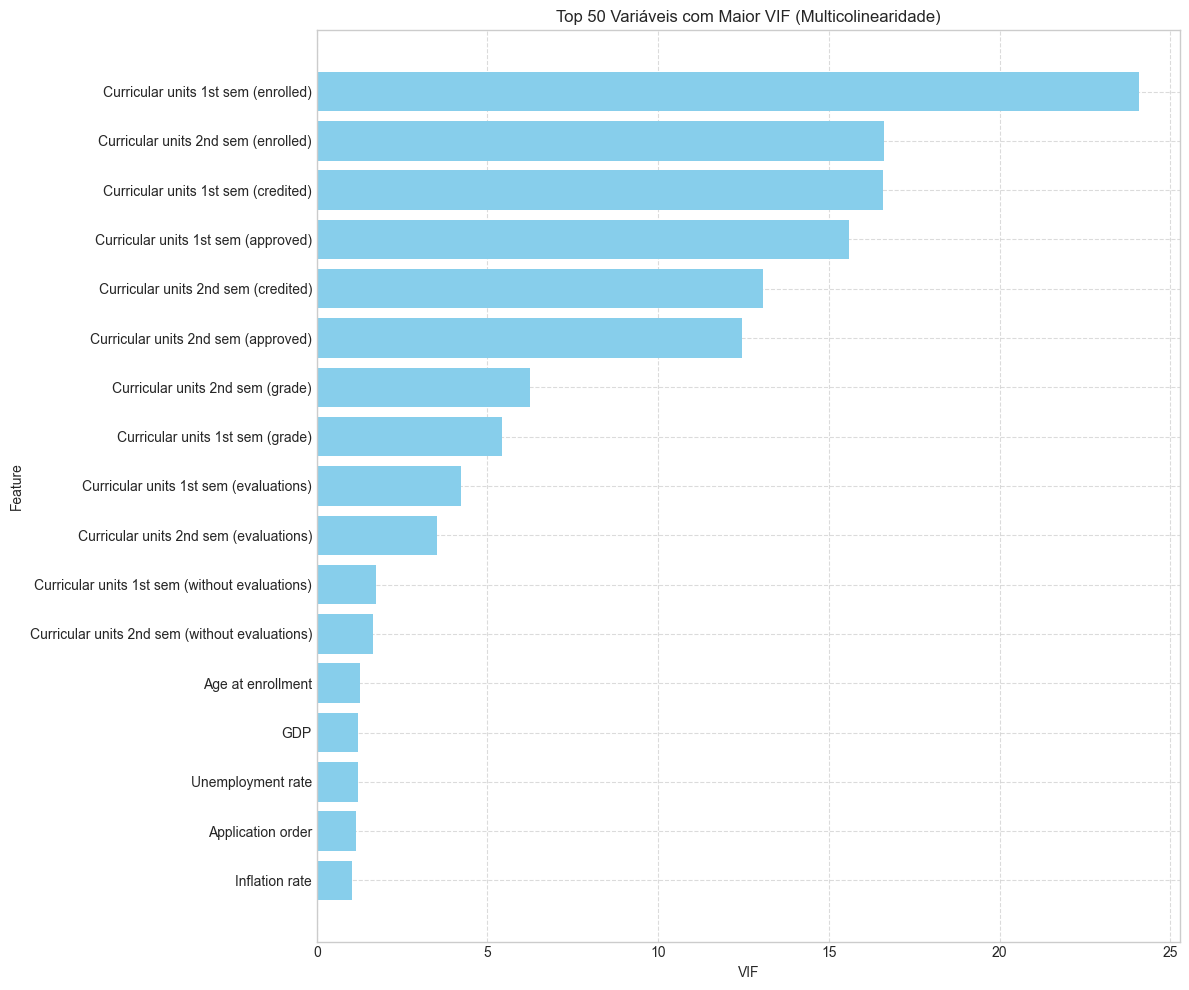

In [12]:
# X_dum = pd.get_dummies(df, drop_first=True)
# X_dum = X_dum.astype(float)
# X_const = add_constant(X_dum)

X_numeric = df.select_dtypes(include=np.number).dropna()
X_const = add_constant(X_numeric)

vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

top_vif = vif_data[vif_data['feature'] != 'const'].sort_values("VIF", ascending=False).head(50)

plt.figure(figsize=(12, 10))
plt.barh(top_vif["feature"], top_vif["VIF"], color="skyblue")
plt.xlabel("VIF")
plt.ylabel("Feature")
plt.title("Top 50 Variáveis com Maior VIF (Multicolinearidade)")
plt.gca().invert_yaxis()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

#### Interpretação dos Valores de VIF

- $VIF = 1$ : Sem multicolinearidade 
- $1 < VIF < 5$ : Baixa multicolinearidade 
- $5 < VIF < 10$ : Moderada multicolinearidade (atenção)
- $VIF > 10$ : Alta multicolinearidade (problemático)

Um valor alto de VIF é problemático por várias razões. Primeiro, ele indica coeficientes instáveis, pois o modelo tem dificuldade em distinguir os efeitos individuais das variáveis correlacionadas. Além disso, há redundância, já que a variável com VIF alto geralmente não adiciona nova informação, podendo ser prevista pelas demais. Isso também pode levar a overfitting, pois o modelo se ajusta em excesso aos dados de treino ao incorporar variáveis que não contribuem efetivamente para a explicação da variável alvo. Por fim, há uma dificuldade de interpretação, já que se torna confuso identificar qual variável está realmente impactando a resposta.


- **VIF Extremamente Alto (> 10)**: As variáveis Curricular units 1st/2nd sem (enrolled), (credited) e (approved) apresentam VIFs altíssimos, chegando a 24.08. Isso significa que mais de 95% da variância de Curricular units 1st sem (enrolled) pode ser explicada pelas outras variáveis numéricas.
- **VIF Alto (> 5)**: As variáveis de notas (grade) também mostram um VIF elevado.

**Insight Principal**: Isso é totalmente esperado e lógico. O número de matérias em que um aluno se matricula (enrolled), o número de matérias que ele valida (credited) e o número que ele passa (approved) estão intrinsecamente ligados. São diferentes medidas do mesmo conceito fundamental: o volume e o sucesso acadêmico do aluno em um semestre.

A alta multicolinearidade no bloco acadêmico pode ser um problema, especialmente para modelos lineares (como Regressão Logística), pois torna os coeficientes do modelo instáveis e difíceis de interpretar.

##### Possíveis Estratégias

- Remoção cuidadosa das features com VIF alto;
- Feature Engineering: combinar as variáveis correlacionadas para criar novas features mais poderosas e que resolvam a multicolinearidade.
- Usar modelos naturalmente mais robustos à multicolinearidade, como Random Forest, LightGBM, XGBoost, e outrosbaseados em ensemble.

### Análise de Assimetria (Skewness) e Detecção de Outliers


A assimetria mede o grau de distorção da distribuição de uma variável em relação a uma distribuição simétrica (curva de sino). Outliers são pontos de dados que se desviam drasticamente dos demais.

Por que usar?

- Alguns modelos como Regressão Linear e SVMs funcionam melhor com dados que têm uma distribuição próxima da normal (baixa assimetria).

- Identificar outliers nos ajuda a entender se são erros de digitação que precisam ser corrigidos ou se são casos extremos e legítimos que contêm informações importantes sobre o comportamento dos alunos.


--- Gráficos de Densidade de Kernel (KDE) ---


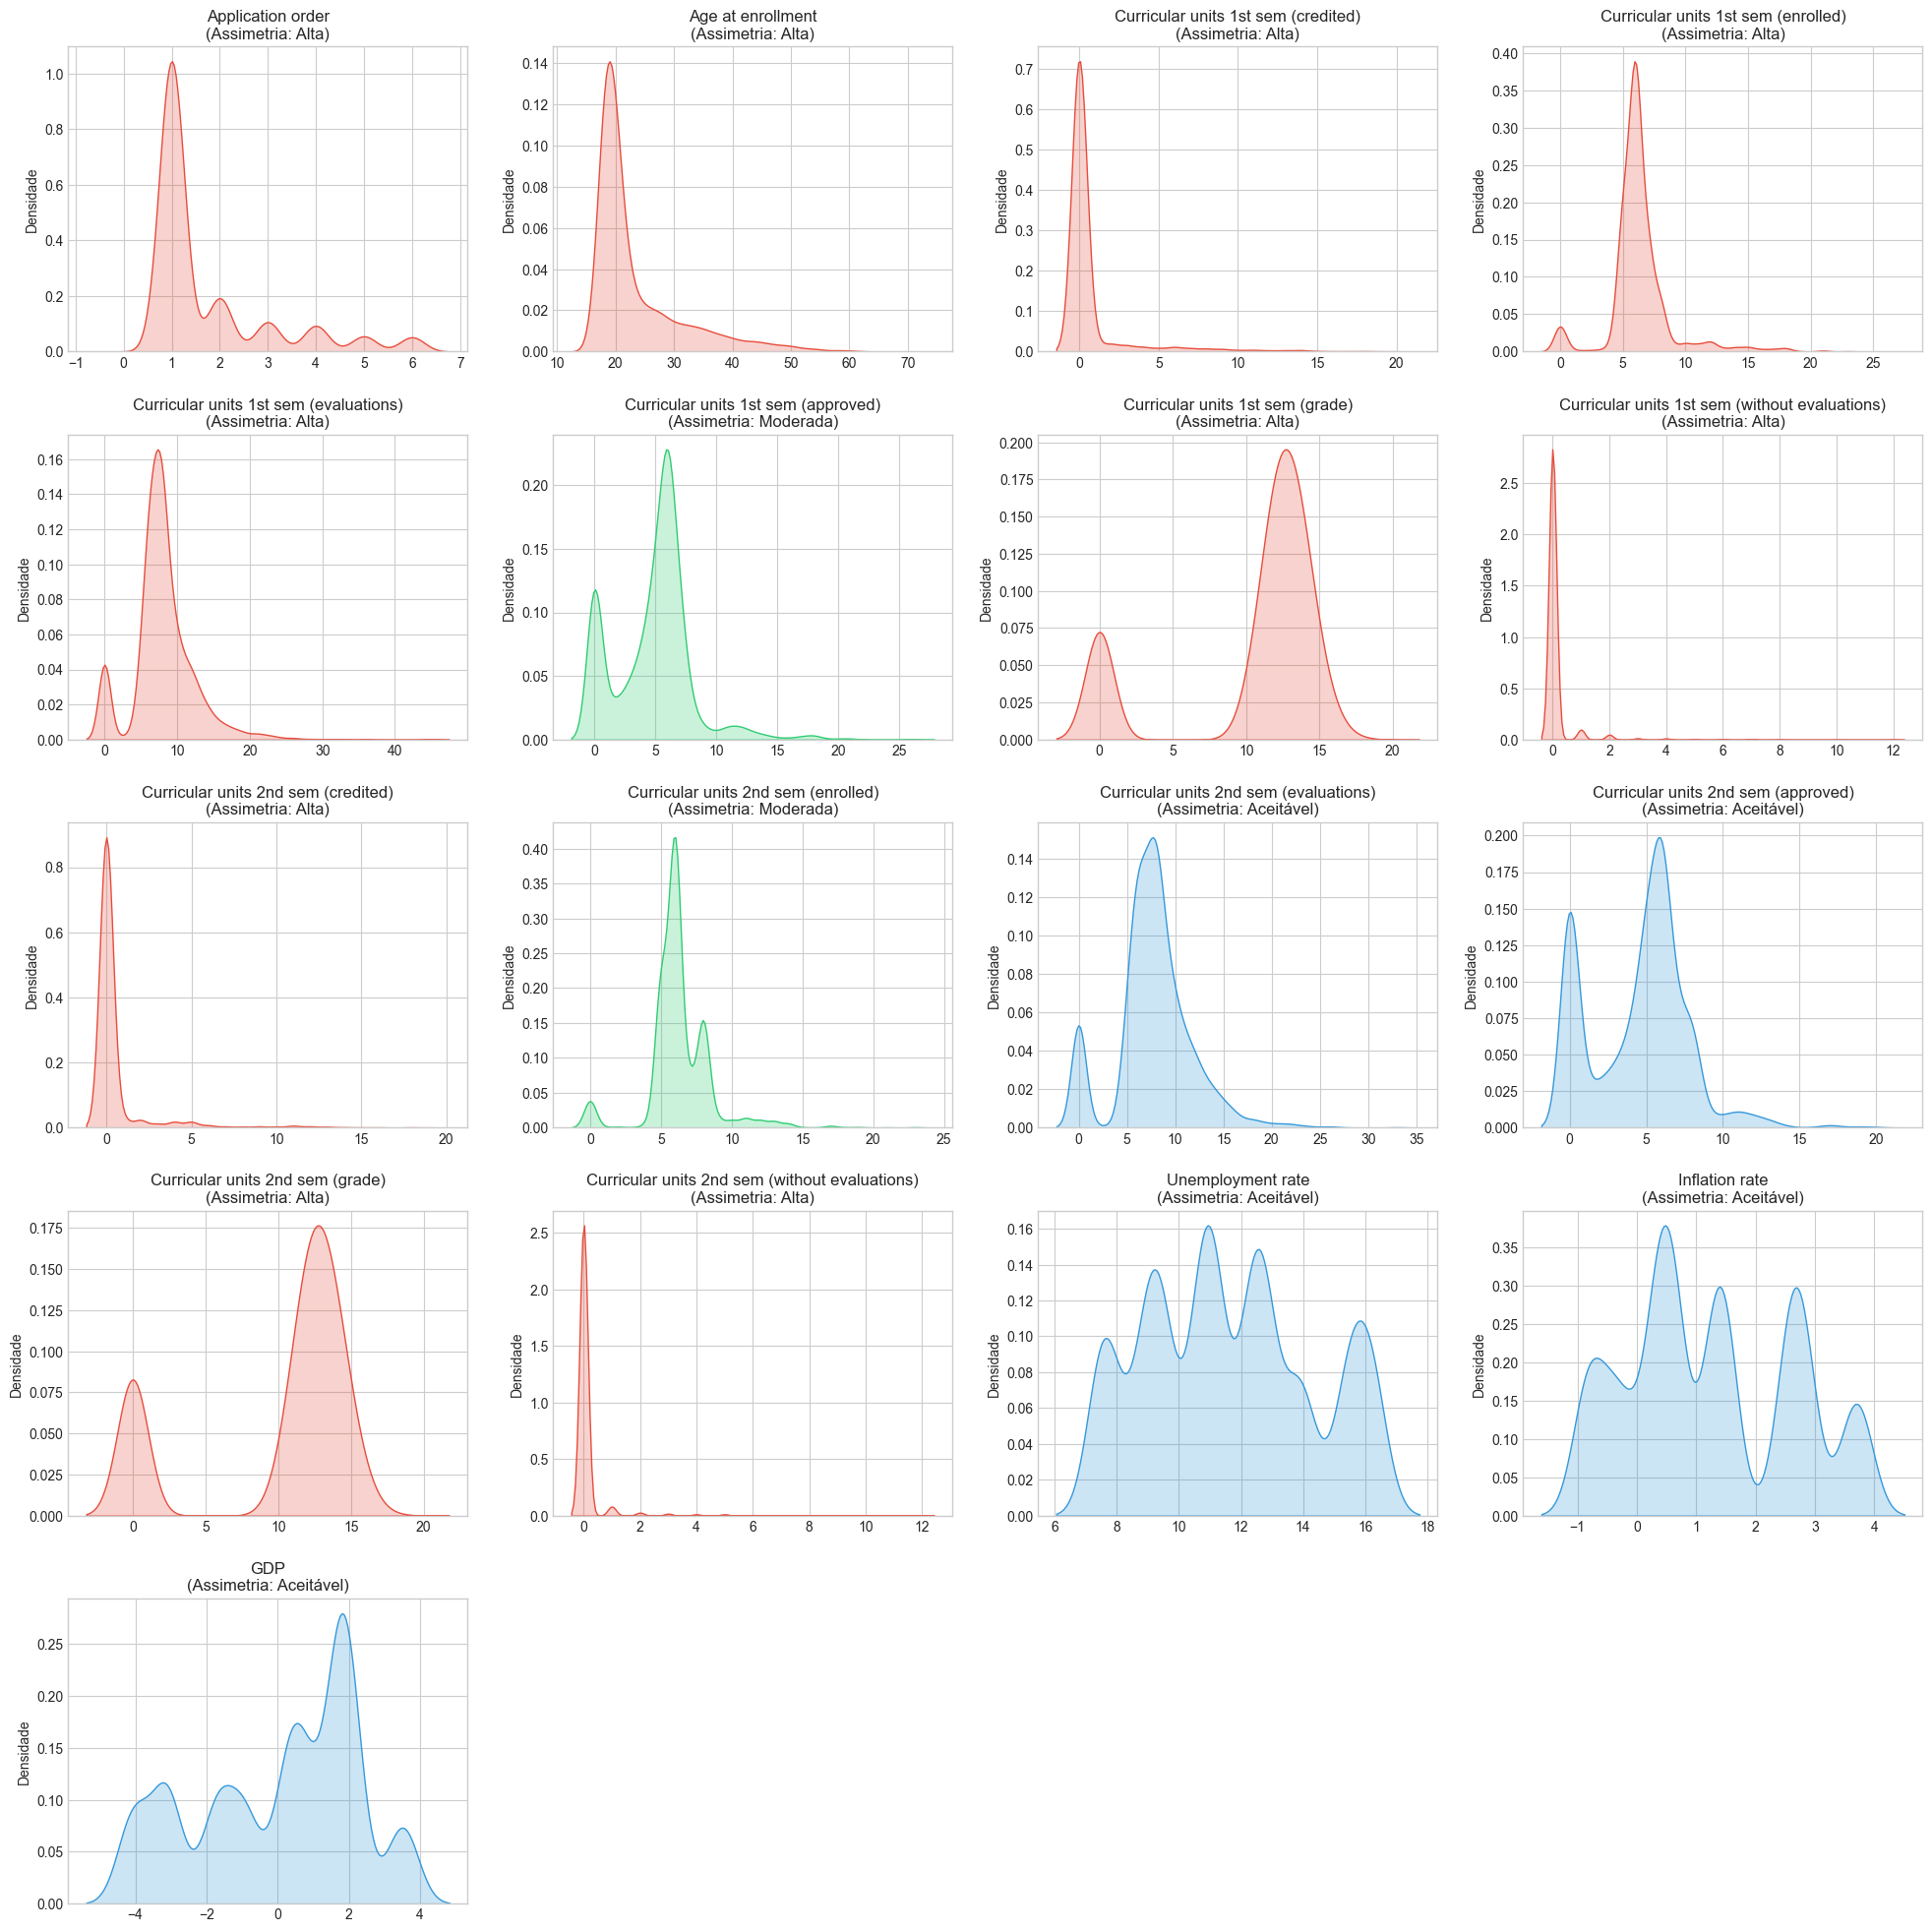

,Skewness,Tipo de Assimetria
Curricular units 1st sem (without evaluations),8.719276,Alta
Curricular units 2nd sem (without evaluations),7.615448,Alta
Curricular units 2nd sem (credited),4.494329,Alta
Curricular units 1st sem (credited),4.064552,Alta
Age at enrollment,1.990725,Alta
Application order,1.817973,Alta
Curricular units 1st sem (enrolled),1.651648,Alta
Curricular units 1st sem (grade),-1.451853,Alta
Curricular units 2nd sem (grade),-1.167812,Alta
Curricular units 1st sem (evaluations),1.146086,Alta


In [13]:
numerical_features = df.select_dtypes(include=np.number)

skewness = numerical_features.skew()
skew_df = pd.DataFrame(skewness, columns=['Skewness']) 

skew_df['Tipo de Assimetria'] = skew_df['Skewness'].apply(
    lambda x: 'Alta' if abs(x) > 1 else 'Moderada' if abs(x) >= 0.5 else 'Aceitável'
)

color_map = {
    'Alta': '#E74C3C',
    'Moderada': '#2ECC71',
    'Aceitável': '#3498DB'
}

n_features = len(numerical_features.columns)
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

print("\n--- Gráficos de Densidade de Kernel (KDE) ---")
for i, col in enumerate(numerical_features.columns):
    tipo_assimetria = skew_df.loc[col, 'Tipo de Assimetria']
    plot_color = color_map[tipo_assimetria]

    sns.kdeplot(ax=axes[i], data=df, x=col, fill=True, color=plot_color)
    
    axes[i].set_title(f'{col}\n(Assimetria: {tipo_assimetria})', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Densidade')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(pad=2.0)
plt.show()

skew_df_sorted = skew_df.sort_values(by='Skewness', key=abs, ascending=False)
display(skew_df_sorted)

- As variáveis com a maior assimetria positiva, de longe, são `Curricular units (without evaluations)` e `Curricular units (credited)`. Isso indica um comportamento de "tudo ou nada". A grande maioria dos alunos tem um valor de zero para essas variáveis (ou seja, participam de todas as avaliações e não têm créditos anteriores para validar). No entanto, uma pequena minoria de alunos se desvia desse padrão (não comparece a avaliações ou vem de transferências com muitos créditos), criando uma "cauda" longa e positiva na distribuição. Essas não são apenas variáveis, são fortes indicadores de perfis de alunos distintos: o aluno desengajado e o aluno transferido.

- As únicas variáveis com assimetria negativa significativa são as notas (grade) do 1º e 2º semestres. Isso é causado por um "efeito teto". A escala de notas tem um valor máximo (ex: 20). A maioria dos alunos que permanecem no curso e são aprovados tende a ter um bom desempenho, com as notas se concentrando na parte superior da escala. Um número menor de alunos tem um desempenho muito ruim, o que "puxa" a cauda da distribuição para a esquerda (em direção à nota zero). Isso sugere que notas muito baixas são a exceção, não a regra.

Para as variáveis com assimetria Alta (tanto positiva quanto negativa), é altamente recomendável aplicar uma transformação (como a logarítmica, `np.log1p`) antes de treinar modelos sensíveis à escala, como Regressão Logística, SVM, Naive Bayes ou Redes Neurais. Isso ajuda o modelo a funcionar melhor.



--- Detecção Visual de Outliers ---


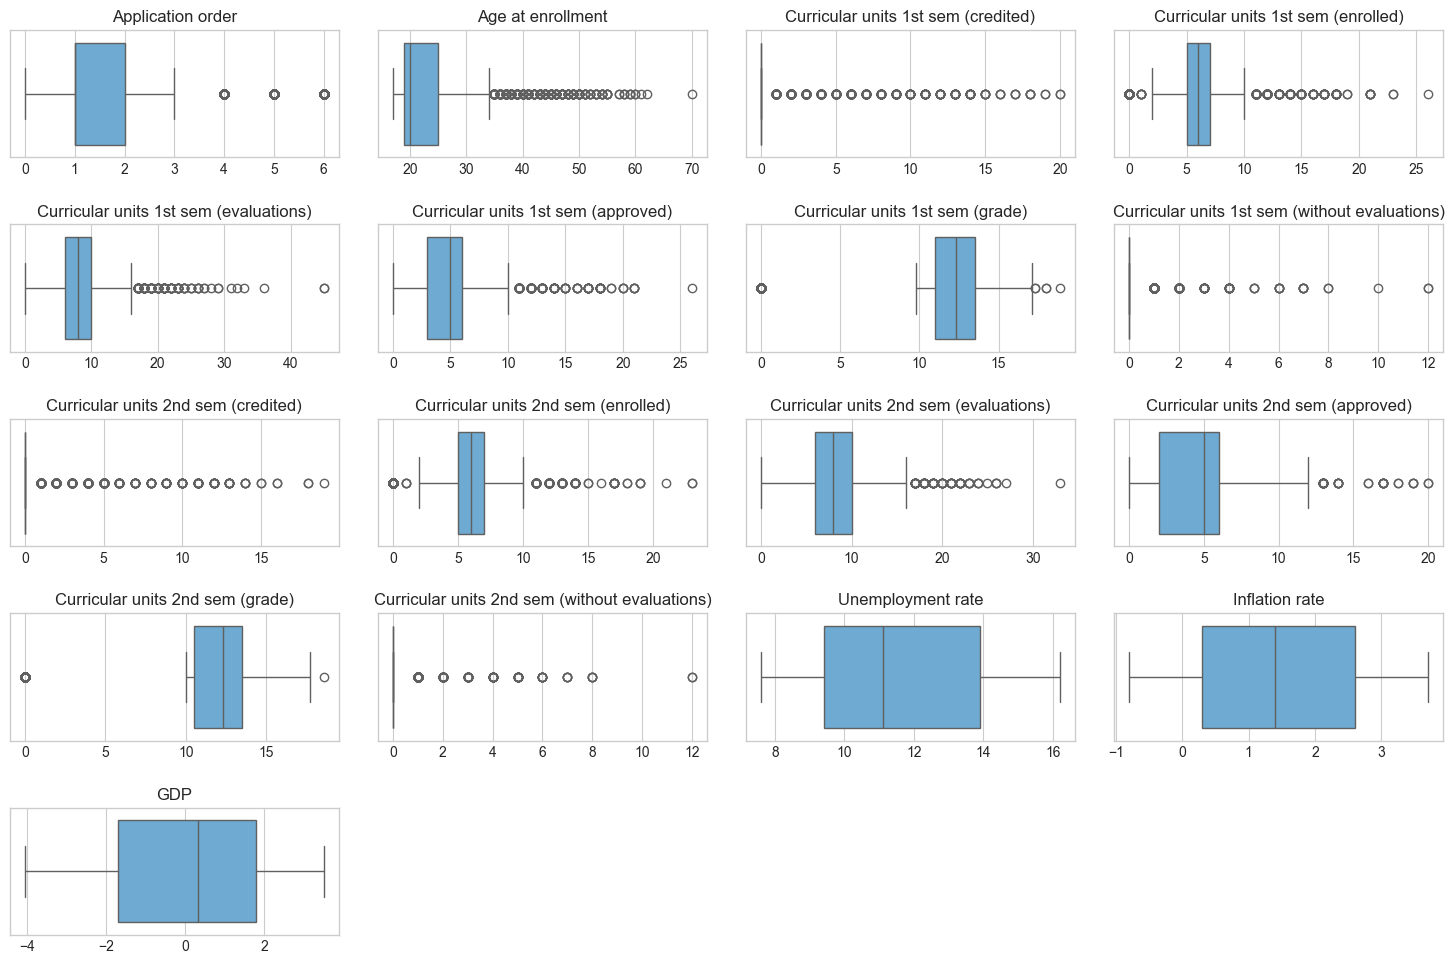

In [14]:
print("\n\n--- Detecção Visual de Outliers ---")

n_features = len(numerical_features.columns)
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 2))
axes = axes.flatten()
    
for i, col in enumerate(numerical_features.columns):
    sns.boxplot(ax=axes[i], x=numerical_features[col], color='#5DADE2')
    axes[i].set_title(col, fontsize=12)
    axes[i].set_xlabel('')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(pad=2.0)
plt.show()

- **Age at enrollment (Idade de Ingresso)**: O box plot mostra claramente uma concentração de alunos na faixa etária tradicional (18-22 anos). Os inúmeros pontos de outlier à direita, indo até os 70 anos, são os alunos maduros ("mature students"). Eles são um grupo demográfico distinto e fundamental para a análise, não um erro.

- **Curricular units ... (credited) (Unidades Creditadas)**: O "box" está achatado no zero, o que significa que a maioria dos alunos não valida nenhuma matéria. Todos os pontos de outlier são, na verdade, os alunos transferidos ou com qualificações anteriores.

- **Curricular units ... (without evaluations) (Unidades sem Avaliação)**: Este é talvez o insight mais crítico. O box também está achatado no zero, indicando que o comportamento normal é participar de todas as avaliações. Os outliers, portanto, são os alunos desengajados. Cada ponto aqui é um forte sinal de alerta de evasão.

- **Curricular units ... (grade) (Notas)**: Os outliers aqui estão principalmente na extremidade inferior. Enquanto a maioria dos alunos se concentra em notas mais altas (o "box"), os outliers de nota baixa representam os alunos com grande dificuldade acadêmica, que são os mais propensos a evadir.

- **Curricular units ... (approved) (Unidades Aprovadas)**: Os outliers na extremidade superior representam os alunos de altíssimo desempenho, que conseguem ser aprovados em um número de matérias bem acima da média.

- **Dados Macroeconômicos (Unemployment rate, Inflation rate, GDP)**: Como esperado, essas variáveis mostram distribuições muito mais simétricas e com poucos ou nenhum outlier. Isso ocorre porque são dados agregados de uma economia, não refletindo comportamentos individuais extremos.

##### Conclusão

Não deve ser removido nenhum outlier. Remover esses pontos significaria apagar a informação sobre os perfis mais importantes para um modelo preditivo: os alunos maduros, os transferidos, os desengajados e os com desempenho muito baixo. Isso prejudicaria drasticamente a capacidade do modelo de prever a evasão.

In [15]:
df.columns

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)

## Feature Engineering

A etapa de Engenharia de Features é onde os insights da nossa análise exploratória e estatística é usada para transformar os dados brutos em "sinais" muito mais claros e enriquecidos para o um modelo preditivo. Quanto melhor q qualidade das features, melhor o modelo.

Modelos matemáticos não entendem texto solto (como 'Dropout' ou 'Graduate'). É preciso convertê-los em números, e a melhor abordagem depende da natureza de cada variável. Por isso, usamos uma estratégia híbrida baseada na cardinalidade (o número de categorias únicas):

| Característica         | One-Hot Encoding (`OneHotEncoder`)                                                                            | Target Encoding (`TargetEncoder`)                                                                                             |
|:-----------------------|:--------------------------------------------------------------------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------------|
| **O que faz?** | Cria uma nova coluna binária (0 ou 1) para **cada categoria** da variável original.                               | Substitui cada categoria por um **único número**: a média do alvo (`Target`) para aquela categoria.                             |
| **Quando Usar?** | Variáveis com **baixa cardinalidade** (poucas categorias únicas, ex: 2 a 5). <br> *Ex: `Gender`, `Displaced`.* | Variáveis com **alta cardinalidade** (muitas categorias únicas, ex: 6 ou mais). <br> *Ex: `Course`, `Mother's occupation`.* |
| **Vantagem Principal** | Representação completa e "honesta" dos dados, sem assumir relações de ordem ou valor entre as categorias.       | Extremamente eficiente. Captura o poder preditivo em uma única coluna, evitando a "maldição da dimensionalidade".            |
| **Desvantagem Principal**| Inviável para alta cardinalidade (cria colunas demais, ex: 30 cursos -> 29 novas colunas).                     | Maior risco de overfitting. Requer técnicas cuidadosas (como a validação cruzada) para ser robusto.   |
| **Exemplo Prático** | A coluna `Gender` com valores 'Male' e 'Female' se transforma na coluna `Gender_Male` com valores 0 ou 1.     | A categoria `'Enfermagem'` na coluna `Course` é substituída pelo valor `0.18` (se a taxa de evasão em Enfermagem for 18%). |

In [16]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, drop_weak_features=True, rare_threshold=0.01):
        self.drop_weak_features = drop_weak_features
        self.rare_threshold = rare_threshold

    def fit(self, X, y):
        if not isinstance(y, pd.Series):
            y = pd.Series(y, name='Target')
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        if not is_numeric_dtype(y) or y.dtype.name == 'category':
            if y.unique().tolist() == ['Graduate', 'Dropout'] or 'Dropout' in y.unique().tolist():
                y = y.apply(lambda x: 1 if x == 'Dropout' else 0).rename('Target')
            else:
                y = pd.to_numeric(y, errors='coerce').fillna(0).astype(int) 

        self.course_grade_map_1sem_ = X.groupby('Course', observed=False)['Curricular units 1st sem (grade)'].mean()
        self.course_grade_map_2sem_ = X.groupby('Course', observed=False)['Curricular units 2nd sem (grade)'].mean()
        self.global_grade_mean_1sem_ = X['Curricular units 1st sem (grade)'].mean()
        self.global_grade_mean_2sem_ = X['Curricular units 2nd sem (grade)'].mean()

        original_categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
        self.ohe_cols_ = [col for col in original_categorical_cols if X[col].nunique() <= 5]
        self.target_cols_ = [col for col in original_categorical_cols if X[col].nunique() > 5]
        
        self.target_cols_.append('interacao_curso_genero')
        self.ohe_cols_.append('faixa_etaria')

        # Lógica para aprender quais categorias são raras em TODAS as colunas categóricas originais
        self.rare_maps_ = {}
        # As qualificações dos pais são tratadas numericamente, então as excluímos deste passo.
        cols_to_check_for_rares = [col for col in original_categorical_cols if col not in ["Mother's qualification", "Father's qualification"]]
        for col in cols_to_check_for_rares:
            counts = X[col].value_counts(normalize=True)
            rare_cats = counts[counts < self.rare_threshold].index.tolist()
            if rare_cats:
                self.rare_maps_[col] = rare_cats

        X_temp_for_fit = X.copy()
        for col, rare_list in self.rare_maps_.items():
            X_temp_for_fit[col] = X_temp_for_fit[col].astype(str).replace(rare_list, 'Other')
        
        X_temp_for_fit['interacao_curso_genero'] = X_temp_for_fit['Course'].astype(str) + '_' + X_temp_for_fit['Gender'].astype(str)
        X_temp_for_fit['faixa_etaria'] = pd.cut(X_temp_for_fit['Age at enrollment'], bins=[0, 20, 25, 40, 100], labels=['Tradicional_Jovem', 'Tradicional_Adulto', 'Maduro', 'Maduro_Senior'], right=False)

        for col in self.target_cols_ + self.ohe_cols_:
             if col in X_temp_for_fit.columns:
                X_temp_for_fit[col] = X_temp_for_fit[col].astype(str)
        
        self.target_maps_ = {}
        self.global_mean_ = y.mean()
        for col in self.target_cols_:
            if col == 'interacao_curso_genero':
                interaction_series = X_temp_for_fit['Course'].astype(str) + '_' + X_temp_for_fit['Gender'].astype(str)
                self.target_maps_[col] = pd.concat([interaction_series.rename(col), y], axis=1).groupby(col, observed=False)[y.name].mean()
            else:
                self.target_maps_[col] = pd.concat([X_temp_for_fit[col], y], axis=1).groupby(col, observed=False)[y.name].mean()
        
        self.target_encoder_ = TargetEncoder(target_type='binary')
        self.target_encoder_.fit(X_temp_for_fit[self.target_cols_], y)

        self.ohe_ = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
        self.ohe_.fit(X_temp_for_fit[self.ohe_cols_])
        
        return self

    def transform(self, X):
        X_transformed = X.copy()

        X_transformed['nivel_educacional_pais'] = (X_transformed["Mother's qualification"].astype(int) + X_transformed["Father's qualification"].astype(int))
        X_transformed['indice_estresse_financeiro'] = (X_transformed['Debtor'].astype(int) - X_transformed['Scholarship holder'].astype(int) + (1 - X_transformed['Tuition fees up to date'].astype(int)))

        for col, rare_list in self.rare_maps_.items():
            X_transformed[col] = X_transformed[col].astype(str).replace(rare_list, 'Other')

        X_transformed['interacao_curso_genero'] = X_transformed['Course'].astype(str) + '_' + X_transformed['Gender'].astype(str)
        X_transformed['faixa_etaria'] = pd.cut(X_transformed['Age at enrollment'], bins=[0, 20, 25, 40, 100], labels=['Tradicional_Jovem', 'Tradicional_Adulto', 'Maduro', 'Maduro_Senior'], right=False).astype(str)
        
        if hasattr(self, 'course_grade_map_1sem_'):
            avg_grade_1sem = X_transformed['Course'].astype(str).map(self.course_grade_map_1sem_).fillna(self.global_grade_mean_1sem_)
            X_transformed['desvio_nota_1sem'] = X_transformed['Curricular units 1st sem (grade)'] - avg_grade_1sem
            avg_grade_2sem = X_transformed['Course'].astype(str).map(self.course_grade_map_2sem_).fillna(self.global_grade_mean_2sem_)
            X_transformed['desvio_nota_2sem'] = X_transformed['Curricular units 2nd sem (grade)'] - avg_grade_2sem

        X_transformed['taxa_aprovacao_1sem'] = (X_transformed['Curricular units 1st sem (approved)'] / X_transformed['Curricular units 1st sem (enrolled)']).fillna(0)
        X_transformed['taxa_aprovacao_2sem'] = (X_transformed['Curricular units 2nd sem (approved)'] / X_transformed['Curricular units 2nd sem (enrolled)']).fillna(0)
        X_transformed['progresso_academico'] = X_transformed['taxa_aprovacao_2sem'] - X_transformed['taxa_aprovacao_1sem']
        total_without_evals = X_transformed['Curricular units 1st sem (without evaluations)'] + X_transformed['Curricular units 2nd sem (without evaluations)']
        X_transformed['aluno_desengajado'] = (total_without_evals > 0).astype(int)

        for col in self.target_cols_ + self.ohe_cols_:
            if col in X_transformed.columns:
                X_transformed[col] = X_transformed[col].astype(str)
                
        target_encoded_data = self.target_encoder_.transform(X_transformed[self.target_cols_])
        target_encoded_df = pd.DataFrame(target_encoded_data, index=X_transformed.index, columns=[f"{c}_encoded" for c in self.target_cols_])

        ohe_data = self.ohe_.transform(X_transformed[self.ohe_cols_])
        ohe_df = pd.DataFrame(ohe_data, index=X_transformed.index, columns=self.ohe_.get_feature_names_out(self.ohe_cols_))
        
        X_final = X_transformed
        X_final = pd.concat([X_final, target_encoded_df, ohe_df], axis=1)

        cols_to_drop = [
            # Categóricas substituídas por encoders
            'Marital status', 'Application mode', 'Course', 'Daytime/evening attendance', 
            'Previous qualification', 'Nacionality', "Mother's occupation", 
            "Father's occupation", 'Displaced', 'Educational special needs', 'Gender', 'International',
            # Numéricas substituídas por features de engenharia
            'Curricular units 1st sem (approved)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (grade)',
            'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (grade)',
            'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (without evaluations)',
            'Debtor', 'Tuition fees up to date', 'Scholarship holder', 
            "Mother's qualification", "Father's qualification", 'Age at enrollment'
        ]
        
        X_final = X_final.drop(columns=cols_to_drop, errors='ignore')
        X_final = X_final.drop(columns=['interacao_curso_genero', 'faixa_etaria'], errors='ignore')

        if self.drop_weak_features:
            weak_features = [col for col in X_final.columns if 'International' in col or 'Educational special needs' in col]
            X_final = X_final.drop(columns=weak_features, errors='ignore')
            
        return X_final

O resultado é um dataset completamente numérico e enriquecido, pronto para ser utilizado pelos algoritmos de Machine Learning.

Features Codificadas:
- As colunas terminadas em `_encoded` (ex: `Course_encoded`) contêm os valores do Target Encoding. Cada valor representa a taxa média de evasão associada à categoria original, medindo efetivamente o "risco" de cada uma.
- As colunas terminadas com o nome da categoria (ex: `faixa_etaria_Maduro`) são o resultado do One-Hot Encoding. Elas são "flags" binárias (0 ou 1) que indicam a presença ou ausência de uma determinada característica.


Features Originais Mantidas: Variáveis numéricas que não apresentaram alta multicolinearidade e não foram substituídas por features de engenharia (como Application order e os indicadores macroeconômicos) foram mantidas em sua forma original.

- **Para Reduzir Multicolinearidade (Insight do VIF e Correlação)**: Vimos que as `Curricular units ...` eram altamente correlacionadas. Em vez de usá-las diretamente, criamos taxas como `taxa_aprovacao_ ...` (aprovadas / matriculadas), que são mais informativas e resolvem a redundância.

- **Para Capturar Comportamentos (Insight da Assimetria e Outliers)**: A análise mostrou que `Curricular units (without evaluations)` indicava um comportamento de "tudo ou nada". A feature `aluno_desengajado` transforma essa observação estatística em uma "flag" de risco clara e direta para o modelo.

- **Para Combinar Preditores Fortes (Insight do Qui-Quadrado e ANOVA)**: Nossa análise mostrou que `Debtor`, `Tuition fees up to date` e `Scholarship holder` eram os preditores mais fortes. A feature `indice_estresse_financeiro` os combina em um único e poderoso indicador da situação do aluno.

É importante notar que todo o "aprendizado" necessário para as transformações (como as médias para o Target Encoding e as categorias para o One-Hot Encoding) devem ser feitos apenas com os dados de treino e teste de forma separada. Isso garante que não haja vazamento de dados (data leakage).

# Model Selection

In [17]:
X = df.drop('Target', axis=1)
y = df['Target'].map({'Dropout': 1, 'Graduate': 0})
y.name = 'Target'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, stratify=y)

## MLP e Naive Bayes (Analise Focada)

In [18]:
class ReflectionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.max_values_ = None

    def fit(self, X, y=None):
        # Aprende o valor máximo de cada coluna nos dados de treino
        self.max_values_ = X.max()
        return self

    def transform(self, X):
        # Aplica a fórmula de reflexão: (max + 1) - valor
        return (self.max_values_ + 1) - X


In [19]:


class DynamicPreprocessor(BaseEstimator, TransformerMixin):
    """
    Recebe um dataframe com features já criadas, analisa suas
    distribuições (assimetria) e aplica o pré-processamento correto
    (log, reflexão, escalonamento) a cada subconjunto de colunas.
    Isso ajuda a normalizar a distribuição de features, sendo extremamente
    importante para modelos como o Gaussian Naive Bayes, que parte da premissa
    de normalidade dos dados para treinamento.
    """
    def __init__(self, positive_skew_threshold=1.0, negative_skew_threshold=-1.0):
        self.positive_skew_threshold = positive_skew_threshold
        self.negative_skew_threshold = negative_skew_threshold

    def fit(self, X, y=None):
        skewness = X.skew(numeric_only=False)
        
        self.positive_skew_features_ = skewness[skewness > self.positive_skew_threshold].index.tolist()
        self.negative_skew_features_ = skewness[skewness < self.negative_skew_threshold].index.tolist()
        
        all_numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
        ohe_cols = [col for col in X.columns if '_' in col and X[col].nunique() <= 2]
        passthrough_features = ohe_cols + [col for col in X.columns if 'aluno_desengajado' in col]

        self.numeric_no_skew_features_ = [
            col for col in all_numeric_cols 
            if col not in self.positive_skew_features_ and col not in self.negative_skew_features_ and col not in passthrough_features
        ]

        self.preprocessor_ = ColumnTransformer(
            transformers=[
                ('pos_skew', SklearnPipeline(
                    steps=[
                        ('log', FunctionTransformer(np.log1p)), 
                        ('scaler', StandardScaler())
                    ]
                ), self.positive_skew_features_),
                ('neg_skew', SklearnPipeline(
                    steps=[
                        ('reflect', ReflectionTransformer()), 
                        ('log', FunctionTransformer(np.log1p)), 
                        ('scaler', StandardScaler())
                    ]
                ), self.negative_skew_features_),
                ('no_skew', StandardScaler(), self.numeric_no_skew_features_)
            ],
            remainder='passthrough'
        )
        
        self.preprocessor_.fit(X)
        return self

    def transform(self, X):
        return self.preprocessor_.transform(X)

In [20]:
models_with_class_weight = {
    "MLP": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42, early_stopping=True, activation='relu', solver='adam', batch_size=64),
    "Naive Bayes": GaussianNB(),
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_predictions_df = pd.DataFrame({'y_real': y_train.copy()})
f1_scores = {}

for name, model in models_with_class_weight.items():
    full_pipeline = SklearnPipeline(
        steps=[
            ('feature_engineer', FeatureEngineer(drop_weak_features=True)),
            ('dynamic_preprocessor', DynamicPreprocessor()),
            ('classifier', model)
        ]
    )
    
    print(f"Processando: {name}...")

    predictions = cross_val_predict(full_pipeline, X_train, y_train, cv=cv_strategy)
    cv_predictions_df[name] = predictions
    
    f1 = cross_val_score(
        estimator=full_pipeline,
        X=X_train,
        y=y_train,
        cv=cv_strategy,
        scoring=make_scorer(
            f1_score
        ),
        n_jobs=-1
    )
    
    f1_scores[name] = (np.mean(f1), np.std(f1))

    print(f"\n--- Resultados da Validação Cruzada modelo {name}---")
    print(f"F1 Score Médio: {f1_scores[name][0]:.4f}")
    print(f"Desvio Padrão dos Scores: {f1_scores[name][1]:.4f}")

Processando: MLP...


/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



--- Resultados da Validação Cruzada modelo MLP---
F1 Score Médio: 0.8732
Desvio Padrão dos Scores: 0.0155
Processando: Naive Bayes...

--- Resultados da Validação Cruzada modelo Naive Bayes---
F1 Score Médio: 0.8137
Desvio Padrão dos Scores: 0.0260


/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Tunagem de Hyperparametros

Para maximizar a capacidade preditiva dos modelos de classificação, foi conduzido um processo de otimização de hiperparâmetros. O objetivo foi encontrar a combinação de parâmetros que maximizasse a performance de cada algoritmo, utilizando o F1-Score da classe minoritária (`Dropout`) como métrica principal de avaliação, por ser robusta a datasets desbalanceados.

A técnica de otimização empregada foi a Busca Bayesiana, implementada através da classe BayesSearchCV da biblioteca scikit-optimize. Esta abordagem é mais eficiente que buscas exaustivas, pois utiliza os resultados de iterações passadas para explorar de forma inteligente o espaço de busca. Para cada modelo, foram realizadas 80 iterações.

A performance de cada combinação de hiperparâmetros foi avaliada utilizando uma estratégia de validação cruzada estratificada com 5 folds (StratifiedKFold), garantindo que a proporção de classes fosse mantida em cada divisão dos dados de treino.

Para o modelo **MLP**, a arquitetura da rede foi mantida fixa para focar a otimização nos parâmetros de treinamento, com duas camadas ocultas de 100 e 50 neurônios, respectivamente. Os demais parâmetros foram configurados da seguinte forma:

- Otimizador (`solver`): adam, um otimizador eficiente baseado em gradiente estocástico.
- Máximo de Épocas (`max_iter`): 500.
- Parada Antecipada (`early_stopping`): Ativada (True) para prevenir overfitting, reservando uma porção dos dados de treino de cada fold para validação interna.

O espaço de busca para os hiperparâmetros otimizados foi:

- Função de Ativação (`activation`): relu e tanh.
- Parâmetro de Regularização Alpha (`alpha`): Escala log-uniforme entre 1e-5 e 1e-1.
- Taxa de Aprendizagem Inicial (`learning_rate_init`): Escala log-uniforme entre 1e-4 e 1e-2.
- Tamanho do Lote (`batch_size`): Valores inteiros entre 8 e 128.

Diferente do MLP, o modelo **Gaussian Naive Bayes** possui menos hiperparâmetros. A otimização focou no parâmetro de suavização de variância, que é crucial para a estabilidade numérica do algoritmo.

O espaço de busca para o hiperparâmetro otimizado foi:

- Suavização de Variância (`var_smoothing`): Escala log-uniforme entre 1e-10 e 1e-3.

In [21]:
search_space_mlp = {
    'classifier__activation': Categorical(['relu', 'tanh']),
    'classifier__alpha': Real(1e-5, 1e-1, 'log-uniform'),
    'classifier__learning_rate_init': Real(1e-4, 1e-2, 'log-uniform'),
    'classifier__batch_size': Integer(8, 128)
}

search_space_nb = {
    'classifier__var_smoothing': Real(1e-10, 1e-3, 'log-uniform'),
}

models_to_optimize = {
    "MLP": (MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42, early_stopping=True, solver='adam'), search_space_mlp),
    "Naive Bayes": (GaussianNB(), search_space_nb),
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_estimators = {}

print(f"--- Iniciando Otimização Bayesiana ---")
for name, (model, search_space) in models_to_optimize.items():
    
    full_pipeline = SklearnPipeline(steps=[
        ('feature_engineser', FeatureEngineer(drop_weak_features=True)),
        ('dynamic_preprocessor', DynamicPreprocessor()),
        ('classifier', model)
    ])

    # Configuração da Busca Bayesiana
    optimizer = BayesSearchCV(
        estimator=full_pipeline,
        search_spaces=search_space,
        n_iter=80,
        cv=cv_strategy,
        scoring=make_scorer(
            f1_score
        ),
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    print(f"\nOtimizando o modelo: {name}...")
    optimizer.fit(X_train, y_train)
    
    best_estimators[name] = optimizer.best_estimator_
    
    print("Otimização concluída.")
    print(f"Melhor F1-Score (cross-val): {optimizer.best_score_:.4f}")
    print("Melhores Hiperparâmetros encontrados:")
    print(optimizer.best_params_)

--- Iniciando Otimização Bayesiana ---

Otimizando o modelo: MLP...


/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown c

Otimização concluída.
Melhor F1-Score (cross-val): 0.8777
Melhores Hiperparâmetros encontrados:
OrderedDict({'classifier__activation': 'tanh', 'classifier__alpha': 1e-05, 'classifier__batch_size': 8, 'classifier__learning_rate_init': 0.0003200100030459876})

Otimizando o modelo: Naive Bayes...


/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/diogo/Documentos/Projetos/School_dropout/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown c

Otimização concluída.
Melhor F1-Score (cross-val): 0.8137
Melhores Hiperparâmetros encontrados:
OrderedDict({'classifier__var_smoothing': 7.425534359037021e-08})


#### Resultados

**MLP**: Após a otimização, o MLP alcançou um F1-Score médio de 0.8777. A melhor combinação de parâmetros encontrada foi:
- `activation`: `'tanh'`
- `alpha`: `1e-05`
- `batch_size`: `8`
- `learning_rate_init`: `0.00032`

**Naive Bayes**: A otimização resultou em um F1-Score médio de 0.8137. O melhor valor encontrado para o parâmetro foi:
- `var_smoothing`: `7.42e-08`

In [22]:
from sklearn import set_config
set_config(display='diagram')

for name, pipeline in best_estimators.items():
    display(best_estimators[name])

Pipeline(steps=[('feature_engineser', FeatureEngineer()),
                ('dynamic_preprocessor', DynamicPreprocessor()),
                ('classifier',
                 MLPClassifier(activation='tanh', alpha=1e-05, batch_size=8,
                               early_stopping=True,
                               hidden_layer_sizes=(100, 50),
                               learning_rate_init=0.0003200100030459876,
                               max_iter=500, random_state=42))])

Pipeline(steps=[('feature_engineser', FeatureEngineer()),
                ('dynamic_preprocessor', DynamicPreprocessor()),
                ('classifier',
                 GaussianNB(var_smoothing=7.425534359037021e-08))])

### Comparação das Métricas Finais 

Avaliando o melhor modelo: MLP...
Avaliando o melhor modelo: Naive Bayes...


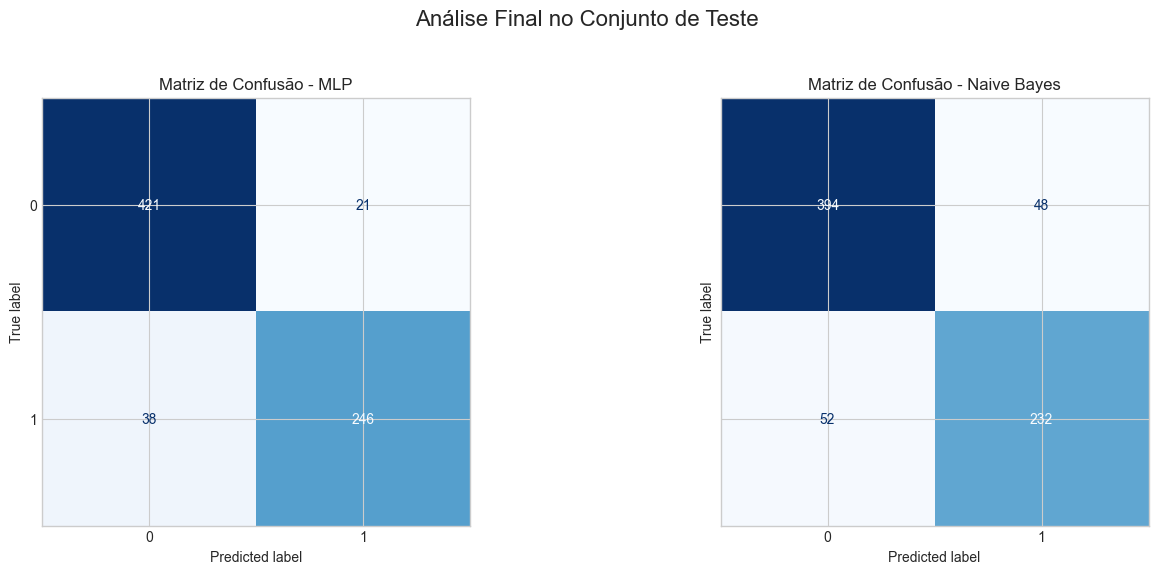

,Precisão (Dropout),Recall (Dropout),F1-Score (Dropout)
MLP,0.9213,0.8662,0.8929
Naive Bayes,0.8286,0.8169,0.8227


In [25]:
final_results = {}

for name, pipeline in best_estimators.items():
    print(f"Avaliando o melhor modelo: {name}...")
    
    y_pred = pipeline.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    
    dropout_metrics = report['1']
    final_results[name] = {
        'Precisão (Dropout)': dropout_metrics['precision'],
        'Recall (Dropout)': dropout_metrics['recall'],
        'F1-Score (Dropout)': dropout_metrics['f1-score']
    }

fig, axes = plt.subplots(1, len(best_estimators), figsize=(14, 6), sharey='row')
fig.suptitle('Análise Final no Conjunto de Teste', fontsize=16)

for i, (name, pipeline) in enumerate(best_estimators.items()):
    ax = axes[i] if len(best_estimators) > 1 else axes
    ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f'Matriz de Confusão - {name}')
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

results_df = pd.DataFrame.from_dict(final_results, orient='index')
results_df = results_df.round(4) 

display(results_df)

#### Análise do Modelo MLP (Multi-Layer Perceptron)

O modelo MLP alcançou um excelente **F1-Score** de 0.8929 para a classe Dropout. Este resultado é um forte indicativo de um modelo bem-sucedido e equilibrado. Analisando em detalhes:

- **Recall** (Sensibilidade) de 0.8662: Significa que o modelo foi capaz de identificar corretamente 86.6% de todos os alunos que realmente iriam evadir. Na prática, de cada 100 alunos em risco, o modelo conseguiu sinalizar aproximadamente 87 para uma possível intervenção.
- **Precisão** de 0.9213: Esta métrica mostra que, quando o modelo previu que um aluno iria evadir, ele estava certo em 92.1% das vezes. Isso demonstra uma alta confiabilidade nos alertas gerados, garantindo que os recursos de apoio sejam direcionados de forma eficiente, com poucos "alarmes falsos".

A Matriz de Confusão confirma essa performance:

- **Falsos Negativos**: Apenas 38 alunos que iriam evadir foram classificados incorretamente como "Graduate".
- **Falsos Positivos**: Apenas 21 alunos que iriam se formar foram classificados incorretamente como "Dropout".

#### Análise do Modelo Gaussian Naive Bayes

O modelo Naive Bayes também apresentou um bom desempenho, com um **F1-Score** de 0.8227.

- **Recall** (Sensibilidade) de 0.8169: O modelo conseguiu identificar 81.7% dos alunos que de fato evadiram. Embora seja um bom resultado, ele é notavelmente inferior à capacidade de detecção do MLP.
- **Precisão** de 0.8286: Das previsões de "Dropout" feitas pelo modelo, 82.9% estavam corretas. É uma boa precisão, mas também inferior à do MLP, indicando uma taxa de "alarmes falsos" um pouco maior.

A Matriz de Confusão do Naive Bayes mostra:

- **Falsos Negativos**: 52 alunos em risco não foram identificados.
- **Falsos Positivos**: 48 alunos seguros foram sinalizados para intervenção.